# RGBD 3D Reconstruction (2-Views)

In [1]:
import numpy as np
import open3d as o3d
import plotly.graph_objects as go
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load Images

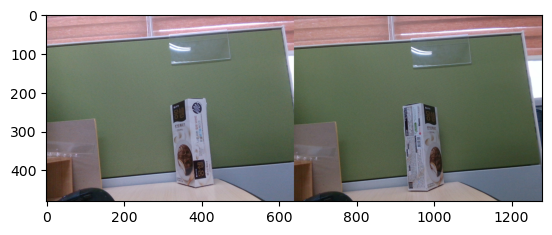

In [2]:
src_rgb1 = cv2.imread('./data/view1.png', 1)
src_rgb2 = cv2.imread('./data/view2.png', 1)
src_depth1 = o3d.io.read_image('./data/depth1.png')
src_depth2 = o3d.io.read_image('./data/depth2.png')

img_concat = cv2.hconcat([src_rgb1, src_rgb2])
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

## Intrinsic parameter

In [4]:
f_x = 618.212
f_y = 617.673
c_x = 323.716
c_y = 256.977
k1 = 0
k2 = 0
K = np.array([[f_x, 0, c_x],
              [0, f_y, c_y],
              [0, 0, 1]], dtype=np.float64)
intrinsic = o3d.camera.PinholeCameraIntrinsic()
intrinsic.intrinsic_matrix = K

## RGBD to point clouds

In [5]:
def GetPCD(rgb_path, depth_path, intrinsic):
  depth_scaling_factor = 999.99
  rgb = o3d.io.read_image(rgb_path)
  depth = o3d.io.read_image(depth_path)
  rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb, depth, depth_scale=depth_scaling_factor, convert_rgb_to_intensity=False, depth_trunc=1)
  pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
  return rgbd, pcd

rgbd1, pcd1 = GetPCD('./data/view1.png', './data/depth1.png', intrinsic)
rgbd2, pcd2 = GetPCD('./data/view2.png', './data/depth2.png', intrinsic)
o3d.visualization.draw_geometries([pcd1])
o3d.visualization.draw_geometries([pcd2])

## Point Clouds Filtering

In [7]:
def GetSegment(pcd):
  # Plane Segmentation
  plane_model, inliers = pcd.segment_plane(distance_threshold=0.02, ransac_n=3, num_iterations=1000)
  [a, b, c, d] = plane_model
  inlier_cloud = pcd.select_by_index(inliers)
  inlier_cloud.paint_uniform_color([1.0, 0, 0])
  segment = pcd.select_by_index(inliers, invert=True)
  return segment

In [8]:
segment1 = GetSegment(pcd1)
segment2 = GetSegment(pcd2)
o3d.visualization.draw_geometries([segment1])
o3d.visualization.draw_geometries([segment2])

## Point Clouds Clustering

In [10]:
def GetCluster(segment):
  with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(segment.cluster_dbscan(eps=0.0145, min_points=150, print_progress=True))
    max_label = labels.max()
    indexes = np.where(labels == 0)
    cluster = o3d.geometry.PointCloud()
    cluster.points = o3d.utility.Vector3dVector(np.asarray(segment.points, np.float32)[indexes])
    cluster.colors = o3d.utility.Vector3dVector(np.asarray(segment.colors, np.float32)[indexes])
  return cluster

In [11]:
cluster1 = GetCluster(segment1)
cluster2 = GetCluster(segment2)
o3d.visualization.draw_geometries([cluster1])
o3d.visualization.draw_geometries([cluster2])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 5
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 10


## 2D Feature extraction

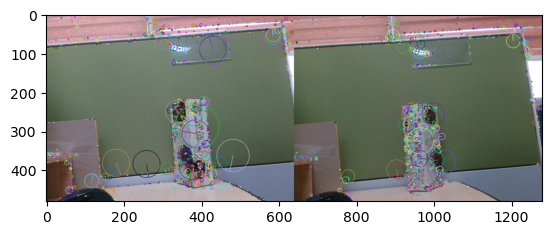

In [12]:
sift = cv2.SIFT_create(nOctaveLayers=20)
kp1, desc1 = sift.detectAndCompute(src_rgb1, None)
kp2, desc2 = sift.detectAndCompute(src_rgb2, None)

img1 = src_rgb1.copy()
cv2.drawKeypoints(src_rgb1, kp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img2 = src_rgb2.copy()
cv2.drawKeypoints(src_rgb2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img_concat = cv2.hconcat([img1, img2])
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

## Get 2D Boundary

In [13]:
def GetBoundary(source_pcd):
  x_min = np.min(np.asarray(source_pcd.points)[:, 0])
  x_max = np.max(np.asarray(source_pcd.points)[:, 0])
  y_min = np.min(np.asarray(source_pcd.points)[:, 1])
  y_max = np.max(np.asarray(source_pcd.points)[:, 1])
  x_min_idx = np.where(np.asarray(source_pcd.points)[:, 0] == x_min)
  x_max_idx = np.where(np.asarray(source_pcd.points)[:, 0] == x_max)
  y_min_idx = np.where(np.asarray(source_pcd.points)[:, 1] == y_min)
  y_max_idx = np.where(np.asarray(source_pcd.points)[:, 1] == y_max)
  u_min = x_min * f_x / (np.asarray(source_pcd.points)[x_min_idx][0][2]) + c_x
  u_max = x_max * f_x / (np.asarray(source_pcd.points)[x_max_idx][0][2]) + c_x
  v_min = y_min * f_y / (np.asarray(source_pcd.points)[y_min_idx][0][2]) + c_y
  v_max = y_max * f_y / (np.asarray(source_pcd.points)[y_max_idx][0][2]) + c_y
  return u_min, u_max, v_min, v_max

In [14]:
min_x1, max_x1, min_y1, max_y1 = GetBoundary(cluster1)
min_x2, max_x2, min_y2, max_y2 = GetBoundary(cluster1)

## 2D Feature Filtering

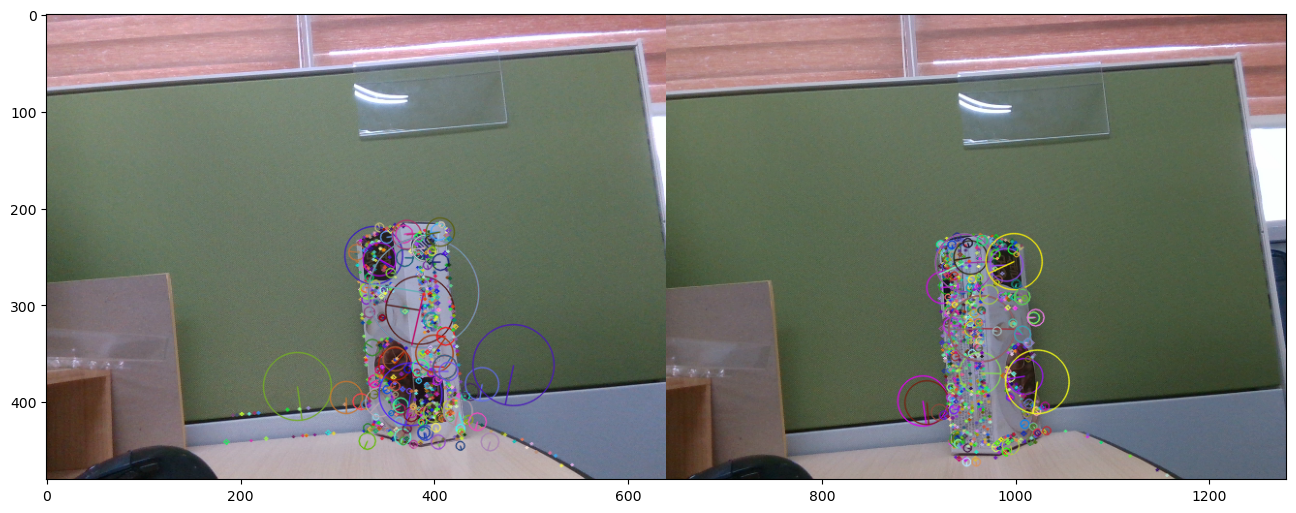

In [22]:
nkp1 = []
ndesc1 = []
nkp2 = []
ndesc2 = []

for i in range(len(kp1)):
  if kp1[i].pt[0] < max_x1 and kp1[i].pt[0] > min_x1 and kp1[i].pt[1] < max_y1 and kp1[i].pt[1] > min_y1:
    nkp1.append(kp1[i])
    ndesc1.append(desc1[i])

for i in range(len(kp2)):
  if kp2[i].pt[0] < max_x2 and kp2[i].pt[0] > min_x2 and kp2[i].pt[1] < max_y2 and kp2[i].pt[1] > min_y2:
    nkp2.append(kp2[i])
    ndesc2.append(desc2[i])

img1 = src_rgb1.copy()
cv2.drawKeypoints(src_rgb1, nkp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2 = src_rgb1.copy()
cv2.drawKeypoints(src_rgb2, nkp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img_concat = cv2.hconcat([img1, img2])
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

## 2D Feature Matching

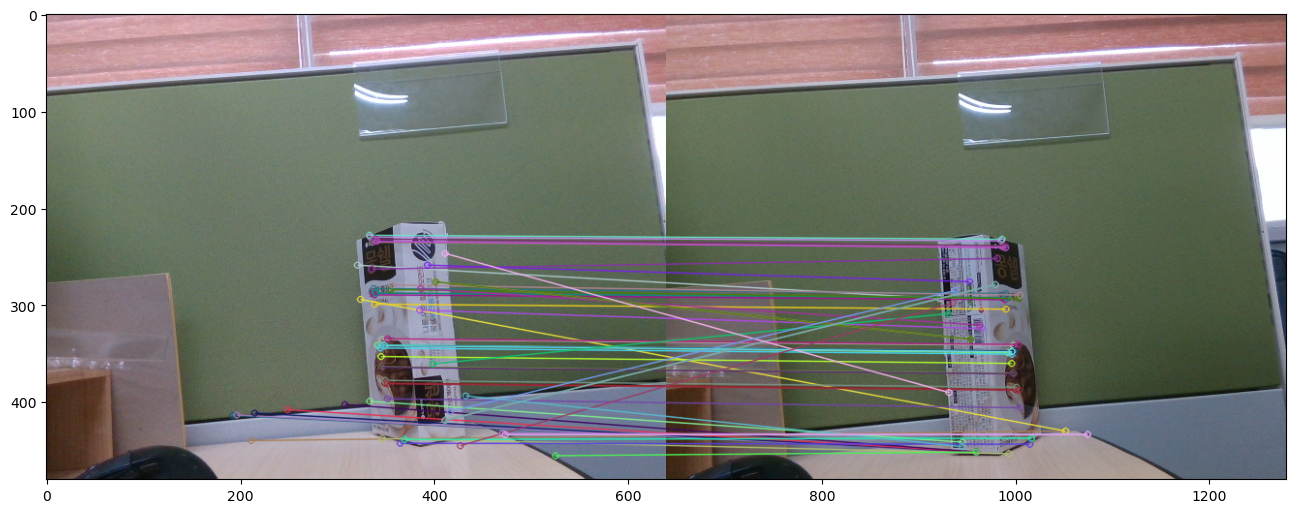

In [21]:
# BFMatcher with default params

bf = cv2.BFMatcher()
matches = bf.knnMatch(np.asarray(ndesc1,np.float32), 
np.asarray(ndesc2,np.float32), k=2)
good = []
for m,n in matches:
  if m.distance < 0.75*n.distance:
    good.append([m])
  res = cv2.drawMatchesKnn(src_rgb1, nkp1, src_rgb2, nkp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

## 3D Pose estimation

In [23]:
pt3d_1 = []
pt3d_2 = []
corr_list = []
depth_scaling_factor = 999.99
for i in range(len(good)):
  u1, v1 = nkp1[good[i][0].queryIdx].pt
  z1 = np.asarray(src_depth1, dtype=np.float64)[np.int32(v1)][np.int32(u1)] / depth_scaling_factor
  x1 = (u1 - K[0,2]) * z1 / K[0,0]
  y1 = (v1 - K[1,2]) * z1 / K[1,1]
  u2, v2 = nkp2[good[i][0].trainIdx].pt
  z2 = np.asarray(src_depth2, dtype=np.float64)[np.int32(v2)][np.int32(u2)] / depth_scaling_factor
  x2 = (u2 - K[0,2]) * z2 / K[0,0]
  y2 = (v2 - K[1,2]) * z2 / K[1,1]
  pt3d_1.append([x1, y1, z1])
  pt3d_2.append([x2, y2, z2])
  corr_list.append([i,i])

pc_1 = o3d.geometry.PointCloud()
pc_2 = o3d.geometry.PointCloud()
pc_1.points = o3d.utility.Vector3dVector(pt3d_1)
pc_2.points = o3d.utility.Vector3dVector(pt3d_2)
corres = o3d.utility.Vector2iVector(corr_list)

icp_result = o3d.pipelines.registration.registration_ransac_based_on_correspondence(pc_1, pc_2, corres, 0.01, 
                                                                                    o3d.pipelines.registration.TransformationEstimationPointToPoint(False), 
                                                                                    3, [], o3d.pipelines.registration.RANSACConvergenceCriteria(1000000, 0.99))
T = icp_result.transformation
print(T)

npcd1 = copy.deepcopy(cluster1).transform(T)
npcd2 = copy.deepcopy(cluster2) 

o3d.visualization.draw_geometries([npcd1, npcd2])

[[-5.87824924e-01  3.20753918e-04 -8.08988106e-01  6.05442103e-01]
 [ 2.40669772e-01  9.54792700e-01 -1.74496307e-01  1.24569997e-01]
 [ 7.72359968e-01 -2.97272261e-01 -5.61328142e-01  1.07152537e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
